<a href="https://colab.research.google.com/github/Axel0087/NLP2023/blob/main/week39%2B41_Huggingface_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# load af Dataset og grundfunktioner

In [1]:
%%capture
!pip install datasets
!pip install bpemb

In [2]:
from torch.utils.data import DataLoader, Dataset
import nltk
from bpemb import BPEmb
import string
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from torch import nn
import torch

In [3]:
dataset = load_dataset("copenlu/answerable_tydiqa")
nltk.download('punkt')

#train_set = dataset["train"]
#validation_set = dataset["validation"]

def get_answer_start(row):
  return row["annotations"]["answer_start"][0]

def get_answer(row):
  return row["annotations"]["answer_text"][0]

def get_document(row):
  return row["document_plaintext"]

def get_question(row):
  return row["question_text"]

def oracle(answer, document):
  return answer != "" and answer in document

def get_language(dataset, lang):
  return dataset.filter(lambda x: x["language"] == lang)#[row for row in dataset if row['language'] == lang]

def get_answerble(dataset):
  return dataset.filter(lambda x: x["annotations"]["answer_start"] != [-1])


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/116067 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13325 [00:00<?, ? examples/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
def add_index(examples, idx):
    # Adding an 'id' field with the index value
    examples["id"] = idx
    return examples

In [5]:
dataset_idx = dataset.map(add_index, with_indices=True)

Map:   0%|          | 0/116067 [00:00<?, ? examples/s]

Map:   0%|          | 0/13325 [00:00<?, ? examples/s]

In [6]:
print(dataset_idx['train'][0])
print(dataset_idx['validation'][0])

{'question_text': 'Milloin Charles Fort syntyi?', 'document_title': 'Charles Fort', 'language': 'finnish', 'annotations': {'answer_start': [18], 'answer_text': ['6. elokuuta (joidenkin lähteiden mukaan 9.) 1874']}, 'document_plaintext': 'Charles Hoy Fort (6. elokuuta (joidenkin lähteiden mukaan 9.) 1874 – 3. toukokuuta 1932) oli yhdysvaltalainen kirjailija ja paranormaalien ilmiöiden tutkija.', 'document_url': 'https://fi.wikipedia.org/wiki/Charles%20Fort', 'id': 0}
{'question_text': 'อยุธยามีกี่อำเภอ ?', 'document_title': 'จังหวัดพระนครศรีอยุธยา', 'language': 'thai', 'annotations': {'answer_start': [42], 'answer_text': ['16']}, 'document_plaintext': '\nปัจจุบันจังหวัดพระนครศรีอยุธยาประกอบด้วย 16 อำเภอ ได้แก่', 'document_url': 'https://th.wikipedia.org/wiki/%E0%B8%88%E0%B8%B1%E0%B8%87%E0%B8%AB%E0%B8%A7%E0%B8%B1%E0%B8%94%E0%B8%9E%E0%B8%A3%E0%B8%B0%E0%B8%99%E0%B8%84%E0%B8%A3%E0%B8%A8%E0%B8%A3%E0%B8%B5%E0%B8%AD%E0%B8%A2%E0%B8%B8%E0%B8%98%E0%B8%A2%E0%B8%B2', 'id': 0}


In [7]:
train_set=dataset_idx['train']
validation_set=dataset_idx['validation']

In [8]:
vocab_size = 25000
encoding_dim = 100

bpemb_ar = BPEmb(lang='ar', dim=encoding_dim, vs=vocab_size)
bpemb_bn = BPEmb(lang='bn', dim=encoding_dim, vs=vocab_size)
bpemb_in = BPEmb(lang='id', dim=encoding_dim, vs=vocab_size)
bpemb_en = BPEmb(lang='en', dim=encoding_dim, vs=vocab_size)

downloading https://nlp.h-its.org/bpemb/ar/ar.wiki.bpe.vs25000.model


100%|██████████| 742254/742254 [00:00<00:00, 1324342.95B/s]


downloading https://nlp.h-its.org/bpemb/ar/ar.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9491724/9491724 [00:01<00:00, 7697271.99B/s] 


downloading https://nlp.h-its.org/bpemb/bn/bn.wiki.bpe.vs25000.model


100%|██████████| 863227/863227 [00:00<00:00, 1531844.26B/s]


downloading https://nlp.h-its.org/bpemb/bn/bn.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9517491/9517491 [00:01<00:00, 7690444.28B/s] 


downloading https://nlp.h-its.org/bpemb/id/id.wiki.bpe.vs25000.model


100%|██████████| 650018/650018 [00:00<00:00, 1162804.02B/s]


downloading https://nlp.h-its.org/bpemb/id/id.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9465922/9465922 [00:01<00:00, 8330882.76B/s] 


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.model


100%|██████████| 661443/661443 [00:00<00:00, 1182229.99B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9477142/9477142 [00:01<00:00, 9241861.78B/s] 


### English

In [9]:
train_english = get_language(train_set, "english")
val_english = get_language(validation_set, "english")

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

In [10]:
train_english_answerble = get_answerble(train_english)
validation_english_answerble = get_answerble(val_english)

Filter:   0%|          | 0/7389 [00:00<?, ? examples/s]

Filter:   0%|          | 0/990 [00:00<?, ? examples/s]

In [11]:
train_english_answerble

Dataset({
    features: ['question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url', 'id'],
    num_rows: 3696
})

In [12]:
train_english_tt = train_english_answerble.train_test_split(test_size=0.2)

In [13]:
train_english_tt['test']

Dataset({
    features: ['question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url', 'id'],
    num_rows: 740
})

### language data

In [14]:
train_arabic = get_language(train_set, "arabic")
val_arabic = get_language(validation_set, "arabic")

train_bengali = get_language(train_set, "bengali")
val_bengali = get_language(validation_set, "bengali")

train_indonesian = get_language(train_set, "indonesian")
val_indonesian = get_language(validation_set, "indonesian")

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

In [15]:
train_arabic_answerble = get_answerble(train_arabic)
val_arabic_answerble = get_answerble(val_arabic)

train_bengali_answerble = get_answerble(train_bengali)
val_bengali_answerble = get_answerble(val_bengali)

train_indonesian_answerble = get_answerble(train_indonesian)
val_indonesian_answerble = get_answerble(val_indonesian)

Filter:   0%|          | 0/29598 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1902 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4779 [00:00<?, ? examples/s]

Filter:   0%|          | 0/224 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11394 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1191 [00:00<?, ? examples/s]

In [16]:
train_arabic_tt = train_arabic_answerble.train_test_split(test_size=0.2)
train_bengali_tt = train_bengali_answerble.train_test_split(test_size=0.2)
train_indonesian_tt = train_indonesian_answerble.train_test_split(test_size=0.2)

#Roberta

In [17]:
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")


In [18]:
!pip install update transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 109.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [19]:
from datasets import load_dataset
from datasets import load_metric
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering
from transformers import AutoConfig
from functools import partial
import torch
import random
import numpy as np
from tqdm import tqdm
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import LambdaLR
from torch import nn
from collections import defaultdict, OrderedDict
MODEL_NAME = 'xlm-roberta-base'
#MODEL_NAME = 'bert-base-uncased'

In [20]:
""" Official evaluation script for v1.1 of the SQuAD dataset. """
from __future__ import print_function
from collections import Counter
import string
import re
import argparse
import json
import sys


def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)


def evaluate_squad(dataset, predictions):
    f1 = exact_match = total = 0
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                total += 1
                if qa['id'] not in predictions:
                    message = 'Unanswered question ' + qa['id'] + \
                              ' will receive score 0.'
                    print(message, file=sys.stderr)
                    continue
                ground_truths = list(map(lambda x: x['text'], qa['answers']))
                prediction = predictions[qa['id']]
                exact_match += metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truths)
                f1 += metric_max_over_ground_truths(
                    f1_score, prediction, ground_truths)

    exact_match = 100.0 * exact_match / total
    f1 = 100.0 * f1 / total

    return {'exact_match': exact_match, 'f1': f1}

def compute_squad(predictions, references):
  pred_dict = {prediction["id"]: prediction["prediction_text"] for prediction in predictions}
  dataset = [
      {
          "paragraphs": [
              {
                  "qas": [
                      {
                          "answers": [{"text": answer_text} for answer_text in ref["answers"]["answer_text"]],
                          "id": ref["id"],
                      }
                      for ref in references
                  ]
              }
          ]
      }
  ]
  score = evaluate_squad(dataset=dataset, predictions=pred_dict)
  return score

In [22]:
# this is also equivalent to those 2 lines. I recommend going with that, unless you want more control over your code
#from datasets import load_metric
#compute_squad = load_metric("squad_v2")

<ipython-input-22-263c584f0d34>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  compute_squad = load_metric("squad_v2")


In [23]:
tk = AutoTokenizer.from_pretrained(MODEL_NAME)


(…)lm-roberta-base/resolve/main/config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

(…)ase/resolve/main/sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

(…)roberta-base/resolve/main/tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [21]:
train_english_tt['test'][70]

{'question_text': 'What was the first race held at the Silverstone Circuit?',
 'document_title': 'Silverstone Circuit',
 'language': 'english',
 'annotations': {'answer_start': [85], 'answer_text': ['an impromptu race']},
 'document_plaintext': "Silverstone was first used for motorsport by an 'ad hoc' group of friends who set up an impromptu race in September 1947. One of their members, Maurice Geoghegan, lived in nearby Silverstone village and was aware that the airfield was deserted. He and eleven other drivers raced over a two-mile circuit, during the course of which Geoghegan himself ran over a sheep that had wandered onto the airfield. The sheep was killed and the car written off, and in the aftermath of this event the informal race became known as the Mutton Grand Prix.[8]",
 'document_url': 'https://en.wikipedia.org/wiki/Silverstone%20Circuit'}

In [22]:
samples = train_english_tt['test'][70]
batch = tk.encode_plus(
        samples['question_text'],
        samples['document_plaintext'],
        padding='max_length',
        truncation='only_second',
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True
    )

In [23]:
batch

{'input_ids': [[0, 4865, 509, 70, 5117, 45712, 34658, 99, 70, 57035, 34165, 167190, 32, 2, 2, 57035, 34165, 509, 5117, 11814, 100, 2926, 10033, 390, 142, 242, 712, 8589, 25, 21115, 111, 23902, 2750, 5423, 1257, 142, 60418, 2676, 458, 45712, 23, 6088, 40191, 5, 6561, 111, 2363, 43032, 4, 204990, 30152, 18788, 1972, 4, 158930, 23, 43573, 1272, 57035, 34165, 54427, 136, 509, 107419, 450, 70, 1831, 28394, 509, 64879, 297, 5, 1529, 136, 103155, 3789, 27941, 7, 45712, 71, 645, 10, 6626, 9, 45207, 61404, 4, 20271, 70, 15411, 111, 3129, 30152, 18788, 1972, 66570, 13028, 645, 10, 2412, 4517, 450, 1902, 259, 7944, 297, 98, 188, 70, 1831, 28394, 5, 581, 2412, 4517, 509, 152388, 136, 70, 2258, 59121, 5773, 4, 136, 23, 70, 7103, 125458, 111, 903, 19732, 70, 152701, 45712, 100512, 51529, 237, 70, 42015, 1507, 12801, 87696, 5, 75064, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

## train_features

In [21]:
def get_train_features(tk, samples):
  '''
  Tokenizes all of the text in the given samples, splittling inputs that are too long for our model
  across multiple features. Finds the token offsets of the answers, which serve as the labels for
  our inputs.
  '''
  batch = tk.batch_encode_plus(
        [[q,c] for q,c in zip(samples['question_text'], samples['document_plaintext'])],
        padding='max_length',
        truncation='only_second',
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True
    )

  # Get a list which maps the input features index to their original index in the
  # samples list (for split inputs). E.g. if our batch size is 4 and the second sample
  # is split into 3 inputs because it is very large, sample_mapping would look like
  # [0, 1, 1, 1, 2, 3]
  sample_mapping = batch.pop('overflow_to_sample_mapping')
  # Get all of the character offsets for each token
  offset_mapping = batch.pop('offset_mapping')

  # Store the start and end tokens
  batch['start_tokens'] = []
  batch['end_tokens'] = []

  # Iterate through all of the offsets
  for i, offsets in enumerate(offset_mapping):
    # Get the right sample by mapping it to its original index
    sample_idx = sample_mapping[i]
    # Get the sequence IDs to know where context starts so we can ignore question tokens
    sequence_ids = batch.sequence_ids(i)

    # Get the start and end character positions of the answer
    ans = samples['annotations'][sample_idx]
    start_char = ans['answer_start'][0]
    end_char = start_char + len(ans['answer_text'][0])
    # while end_char > 0 and (end_char >= len(samples['context'][sample_idx]) or samples['context'][sample_idx][end_char] == ' '):
    #   end_char -= 1

    # Start from the first token in the context, which can be found by going to the
    # first token where sequence_ids is 1
    start_token = 0
    while sequence_ids[start_token] != 1:
      start_token += 1

    end_token = len(offsets) - 1
    while sequence_ids[end_token] != 1:
      end_token -= 1

    # By default set it to the CLS token if the answer isn't in this input
    if start_char < offsets[start_token][0] or end_char > offsets[end_token][1]:
      start_token = 0
      end_token = 0
    # Otherwise find the correct token indices
    else:
      # Advance the start token index until we have passed the start character index
      while start_token < len(offsets) and offsets[start_token][0] <= start_char:
        start_token += 1
      start_token -= 1

      # Decrease the end token index until we have passed the end character index
      while end_token >= 0 and offsets[end_token][1] >= end_char:
        end_token -= 1
      end_token += 1

    batch['start_tokens'].append(start_token)
    batch['end_tokens'].append(end_token)

  #batch['start_tokens'] = np.array(batch['start_tokens'])
  #batch['end_tokens'] = np.array(batch['end_tokens'])

  return batch

def collate_fn(inputs):
  '''
  Defines how to combine different samples in a batch
  '''
  input_ids = torch.tensor([i['input_ids'] for i in inputs])
  attention_mask = torch.tensor([i['attention_mask'] for i in inputs])
  start_tokens = torch.tensor([i['start_tokens'] for i in inputs])
  end_tokens = torch.tensor([i['end_tokens'] for i in inputs])

  # Truncate to max length
  max_len = max(attention_mask.sum(-1))
  input_ids = input_ids[:,:max_len]
  attention_mask = attention_mask[:,:max_len]

  return {'input_ids': input_ids, 'attention_mask': attention_mask, 'start_tokens': start_tokens, 'end_tokens': end_tokens}

In [37]:
train_english_tt['train'][0]

{'question_text': 'What is hegemony?',
 'document_title': 'Hegemony',
 'language': 'english',
 'annotations': {'answer_start': [91],
  'answer_text': ['is the political, economic, or military predominance or control of one state over others.[1][2][3][4] In ancient Greece (8th century BC – 6th century AD), hegemony denoted the politico-military dominance of a city-state over other city-states.[5] The dominant state is known as the hegemon']},
 'document_plaintext': 'Hegemony (UK: /hɪˈɡɛməni, hɪˈdʒɛməni/, US: /hɪˈdʒɛməni/ (pronunciation) or /ˈhɛdʒəˌmoʊni/) is the political, economic, or military predominance or control of one state over others.[1][2][3][4] In ancient Greece (8th century BC – 6th century AD), hegemony denoted the politico-military dominance of a city-state over other city-states.[5] The dominant state is known as the hegemon.[6]',
 'document_url': 'https://en.wikipedia.org/wiki/Hegemony'}

In [38]:
tk.decode(tokenized_dataset['input_ids'][0])


'<s> What is hegemony?</s></s> Hegemony (UK: /hɪˈɡɛməni, hɪˈdʒɛməni/, US: /hɪˈdʒɛməni/ (pronunciation) or /ˈhɛdʒəˌmoʊni/) is the political, economic, or military predominance or control of one state over others.[1][2][3][4] In ancient Greece (8th century BC – 6th century AD), hegemony denoted the politico-military dominance of a city-state over other city-states.[5] The dominant state is known as the hegemon.[6]</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [28]:
tokenized_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'start_tokens', 'end_tokens'],
    num_rows: 3000
})

In [29]:
train_english_tt['test']

Dataset({
    features: ['question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
    num_rows: 740
})

## train

In [22]:
def train(
    model: nn.Module,
    train_dl: DataLoader,
    optimizer: torch.optim.Optimizer,
    schedule: LambdaLR,
    n_epochs: int,
    device: torch.device
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  """

  # Keep track of the loss and best accuracy
  losses = []
  best_acc = 0.0
  pcounter = 0

  # Iterate through epochs
  for ep in range(n_epochs):

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = {b: batch[b].to(device) for b in batch}

      # Pass the inputs through the model, get the current loss and logits
      outputs = model(
          input_ids=batch['input_ids'],
          attention_mask=batch['attention_mask'],
          start_positions=batch['start_tokens'],
          end_positions=batch['end_tokens']
      )
      loss = outputs['loss']
      losses.append(loss.item())
      loss_epoch.append(loss.item())

      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model and advance the LR schedule
      optimizer.step()
      scheduler.step()
      #gc.collect()
  return losses

# validate and predict

In [23]:
def get_validation_features(tk, samples):
  # First, tokenize the text. We get the offsets and return overflowing sequences in
  # order to break up long sequences into multiple inputs. The offsets will help us
  # determine the original answer text
  batch = tk.batch_encode_plus(
        [[q,c] for q,c in zip(samples['question_text'], samples['document_plaintext'])],
        padding='max_length',
        truncation='only_second',
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True
    )

  # We'll store the ID of the samples to calculate squad score
  batch['example_id'] = []
  # The overflow sample map tells us which input each sample corresponds to
  sample_map = batch.pop('overflow_to_sample_mapping')

  for i in range(len(batch['input_ids'])):
    # The sample index tells us which of the values in "samples" these features belong to
    sample_idx = sample_map[i]
    sequence_ids = batch.sequence_ids(i)

    # Add the ID to map these features back to the correct sample
    batch['example_id'].append(samples['id'][sample_idx])

    #Set offsets for non-context words to be None for ease of processing
    batch['offset_mapping'][i] = [o if sequence_ids[k] == 1 else None for k,o in enumerate(batch['offset_mapping'][i])]

  return batch

def val_collate_fn(inputs):
  input_ids = torch.tensor([i['input_ids'] for i in inputs])
  attention_mask = torch.tensor([i['attention_mask'] for i in inputs])

  # Truncate to max length
  max_len = max(attention_mask.sum(-1))
  input_ids = input_ids[:,:max_len]
  attention_mask = attention_mask[:,:max_len]

  return {'input_ids': input_ids, 'attention_mask': attention_mask}

In [24]:
def predict(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like
  # layer normalization and dropout
  model.eval()
  start_logits_all = []
  end_logits_all = []

  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = {b: batch[b].to(device) for b in batch}

      # Pass the inputs through the model, get the current loss and logits
      outputs = model(
          input_ids=batch['input_ids'],
          attention_mask=batch['attention_mask']
      )
      # Store the "start" class logits and "end" class logits for every token in the input
      start_logits_all.extend(list(outputs['start_logits'].detach().cpu().numpy()))
      end_logits_all.extend(list(outputs['end_logits'].detach().cpu().numpy()))


    return start_logits_all,end_logits_all

def post_process_predictions(examples, dataset, logits, num_possible_answers = 20, max_answer_length = 30):
  all_start_logits, all_end_logits = logits
  # Build a map from example to its corresponding features. This will allow us to index from
  # sample ID to all of the features for that sample (in case they were split up due to long input)
  example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
  features_per_example = defaultdict(list)
  for i, feature in enumerate(dataset):
      features_per_example[example_id_to_index[feature["example_id"]]].append(i)

  # Create somewhere to store our predictions
  predictions = OrderedDict()

  # Iterate through each sample in the dataset
  for j, sample in enumerate(tqdm(examples)):

    # Get the feature indices (all of the features split across the batch)
    feature_indices = features_per_example[j]
    # Get the original context which predumably has the answer text
    context = sample['document_plaintext']

    preds = []
    # Iterate through all of the features
    for ft_idx in feature_indices:

      # Get the start and end answer logits for this input
      start_logits = all_start_logits[ft_idx]
      end_logits = all_end_logits[ft_idx]

      # Get the offsets to map token indices to character indices
      offset_mapping = dataset[ft_idx]['offset_mapping']

      # Sort the logits and take the top N
      start_indices = np.argsort(start_logits)[::-1][:num_possible_answers]
      end_indices = np.argsort(end_logits)[::-1][:num_possible_answers]

      # Iterate through start and end indices
      for start_index in start_indices:
        for end_index in end_indices:

          # Ignore this combination if either the indices are not in the context
          if start_index >= len(offset_mapping) or end_index >= len(offset_mapping) or offset_mapping[start_index] is None or offset_mapping[end_index] is None:
            continue

          # Also ignore if the start index is greater than the end index of the number of tokens
          # is greater than some specified threshold
          if start_index > end_index or end_index - start_index + 1 > max_answer_length:
            continue

          ans_text = context[offset_mapping[start_index][0]:offset_mapping[end_index][1]]
          preds.append({
              'score': start_logits[start_index] + end_logits[end_index],
              'text': ans_text
          })

    if len(preds) > 0:
      # Sort by score to get the top answer
      answer = sorted(preds, key=lambda x: x['score'], reverse=True)[0]
    else:
      answer = {'score': 0.0, 'text': ""}

    predictions[sample['id']] = answer['text']
  return predictions

# train model

In [25]:
result_model = {}

In [26]:
# Create the optimizer
lr=2e-5
n_epochs = 3
weight_decay = 0.01
warmup_steps = 200

tk = AutoTokenizer.from_pretrained(MODEL_NAME)


(…)lm-roberta-base/resolve/main/config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

(…)ase/resolve/main/sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

(…)roberta-base/resolve/main/tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [34]:
runs = [#("English", train_english_answerble),
         ("Arabic", train_arabic_answerble),
       #  ("Bengali", train_bengali_answerble),
        # ("Indonesian", train_indonesian_answerble)
]

device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

print(device)
for (tag, ds_train) in runs:

  model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME).to(device)

  no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

  optimizer = AdamW(optimizer_grouped_parameters, lr=lr)

  print(tag)
  tokenized_dataset = ds_train.map(partial(get_train_features, tk), batched=True, remove_columns=ds_train.column_names)
  samples = random.sample(list(range(len(tokenized_dataset))), len(tokenized_dataset))
  tokenized_dataset = tokenized_dataset.select(samples)
  train_dl = DataLoader(tokenized_dataset, collate_fn=collate_fn, shuffle=True, batch_size=4)

  scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps,n_epochs * len(train_dl))
  losses = train(
    model,
    train_dl,
    optimizer,
    scheduler,
    n_epochs,
    device)

  result_model[tag] = [losses, model]#, formatted_predictions, gold, result]

cuda


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Arabic


Map:   0%|          | 0/14805 [00:00<?, ? examples/s]

100%|██████████| 3840/3840 [19:07<00:00,  3.35it/s]


# zero-shot cross-lingual results for sequence labeller

In [28]:
#result_crossed = {}

In [35]:
runs_val = [#("English", train_english_answerble, validation_english_answerble),
          ("Arabic", val_arabic_answerble),
          ("Bengali", val_bengali_answerble),
          ("Indonesian", val_indonesian_answerble)]

for model_tag in result_model:
  model_trained = result_model[model_tag][1]

  for (tag, ds_val ) in runs_val:
    validation_dataset = ds_val.map(partial(get_validation_features, tk), batched=True, remove_columns=ds_val.column_names)
    val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)
    logits = predict(model_trained, val_dl)
    predictions = post_process_predictions(ds_val, validation_dataset, logits)
    formatted_predictions = [{'id': k, 'prediction_text': v} for k,v in predictions.items()]
    gold = [{'id': example['id'], 'answers': example['annotations']} for example in ds_val]
    result = compute_squad(references=gold, predictions=formatted_predictions)
    result_crossed[model_tag,tag] = result
    print(tag,result)

100%|██████████| 951/951 [00:01<00:00, 545.73it/s]


Arabic {'exact_match': 25.65720294426919, 'f1': 38.86334165271503}


100%|██████████| 112/112 [00:00<00:00, 468.99it/s]


Bengali {'exact_match': 51.785714285714285, 'f1': 64.30290939219508}


100%|██████████| 597/597 [00:01<00:00, 574.04it/s]


Indonesian {'exact_match': 37.85594639865997, 'f1': 50.71377199924094}


100%|██████████| 951/951 [00:01<00:00, 535.57it/s]


Arabic {'exact_match': 48.79074658254469, 'f1': 65.68600585897278}


100%|██████████| 112/112 [00:00<00:00, 483.10it/s]


Bengali {'exact_match': 33.035714285714285, 'f1': 48.16559432630861}


100%|██████████| 597/597 [00:01<00:00, 555.09it/s]


Indonesian {'exact_match': 67.50418760469012, 'f1': 79.07609280393567}


100%|██████████| 951/951 [00:01<00:00, 539.06it/s]


Arabic {'exact_match': 61.198738170347006, 'f1': 77.08891091574135}


100%|██████████| 112/112 [00:00<00:00, 492.76it/s]


Bengali {'exact_match': 37.5, 'f1': 51.39812816152101}


100%|██████████| 597/597 [00:01<00:00, 545.74it/s]


Indonesian {'exact_match': 60.971524288107204, 'f1': 76.07638179148938}


In [36]:
result_crossed

{('Bengali', 'Arabic'): {'exact_match': 25.65720294426919,
  'f1': 38.86334165271503},
 ('Bengali', 'Bengali'): {'exact_match': 51.785714285714285,
  'f1': 64.30290939219508},
 ('Bengali', 'Indonesian'): {'exact_match': 37.85594639865997,
  'f1': 50.71377199924094},
 ('Indonesian', 'Arabic'): {'exact_match': 48.79074658254469,
  'f1': 65.68600585897278},
 ('Indonesian', 'Bengali'): {'exact_match': 33.035714285714285,
  'f1': 48.16559432630861},
 ('Indonesian', 'Indonesian'): {'exact_match': 67.50418760469012,
  'f1': 79.07609280393567},
 ('Arabic', 'Arabic'): {'exact_match': 61.198738170347006,
  'f1': 77.08891091574135},
 ('Arabic', 'Bengali'): {'exact_match': 37.5, 'f1': 51.39812816152101},
 ('Arabic', 'Indonesian'): {'exact_match': 60.971524288107204,
  'f1': 76.07638179148938}}

## eksempler

In [91]:
id_30 = validation_english_answerble.filter(lambda x: x["id"]== 30)
id_30[0]

{'question_text': 'What is a way to increase your wound healing speed?',
 'document_title': 'Wound healing',
 'language': 'english',
 'annotations': {'answer_start': [51],
  'answer_text': ['cleaning and protection from reinjury or infection']},
 'document_plaintext': "Wound care encourages and speeds wound healing via cleaning and protection from reinjury or infection. Depending on each patient's needs, it can range from the simplest first aid to entire nursing specialties such as wound, ostomy, and continence nursing and burn center care.",
 'document_url': 'https://en.wikipedia.org/wiki/Wound%20healing',
 'id': 30}

In [111]:
print(formatted_predictions[300:302])
print(gold[300:302])

[{'id': 3736, 'prediction_text': 'at least one primary external dimension of less than 100 nanometers'}, {'id': 3744, 'prediction_text': '14th century'}]
[{'id': 3736, 'answers': {'answer_start': [235], 'answer_text': ['nanometers']}}, {'id': 3744, 'answers': {'answer_start': [38], 'answer_text': ['14th century']}}]


In [112]:
compute_squad(references=gold[300:302], predictions=formatted_predictions[300:302])

{'exact_match': 50.0, 'f1': 58.333333333333336}

In [108]:
compute_squad(references=gold[300:301], predictions=formatted_predictions[300:301])

{'exact_match': 0.0, 'f1': 16.666666666666668}

In [110]:
compute_squad(references=gold[301:302], predictions=formatted_predictions[301:302])

{'exact_match': 100.0, 'f1': 100.0}

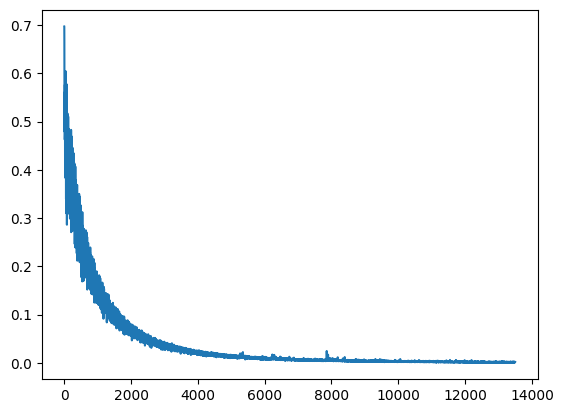

In [ ]:
  plt.plot(results['Bengali'][0])